
<h1 align="center"> Pump it Up: Data Mining the Water Table </h1>
<h2 align="right"> Alex de Vries, 6 September 2021 </h2>

The Ministry wants to know in advance which pumps are most likely to be **non-functional**, so that they can triage their repair efforts. They ask help to come up with a **repair and replace strategy**, that **minimizes time/cost and optimizes water access**. The final analysis should be presented in a presentation style format with slides as if it would be shared with a real client. 

### Background information
- https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/
- https://ednafernandes.medium.com/pump-it-up-data-mining-the-water-table-7d7a5d2ebb38



---

## 1) Preparations

In [52]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [53]:
# Load Data
test_vals = pd.read_csv("test_set_values.csv")
train_vals = pd.read_csv("training_set_values.csv")
train_labs = pd.read_csv("training_set_labels.csv")

train = pd.merge(train_vals, train_labs, on='id')

## 2) Preprocessing/feature selection

id
status_group                  
functional               32259
functional needs repair   4317
non functional           22824

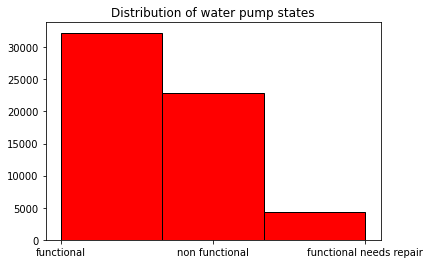

In [54]:
train_labs.status_group.hist(grid=False, bins=3, color='red', edgecolor='black')
plt.title('Distribution of water pump states')

train_labs[['status_group', 'id']].groupby('status_group').count()

In [55]:
# check for features with null values
train.apply(lambda x: sum(x.isnull()))

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [56]:
# To save time I am liberal when it comes to removing features. If a feature with many missing values has 
# many unique values I will remove it for the analysis.
print('amount of unique values for the features which contain missing values')
print('Unique funders: ', len(train.funder.value_counts()))
# conclusion too many unique funders so lets drop this feature

print('Unique villages: ', len(train.subvillage.value_counts()))
# conclusion too many unique villages so lets drop this feature

print('Unique installer: ', len(train.installer.value_counts()))
# conclusion too many unique installers so lets drop this feature

print('Unique scheme_name: ', len(train.scheme_name.value_counts()))
# conclusion too many unique scheme_name so lets drop this feature

print('---')
print('Unique public_meeting: ', len(train.public_meeting.value_counts()))
# maybe useful to keep

print('Unique permit: ', len(train.permit.value_counts()))
# maybe useful to keep

print('Unique scheme_management: ', len(train.scheme_management.value_counts()))
# maybe useful to keep

amount of unique values for the features which contain missing values
Unique funders:  1897
Unique villages:  19287
Unique installer:  2145
Unique scheme_name:  2696
---
Unique public_meeting:  2
Unique permit:  2
Unique scheme_management:  12


In [57]:
# fixing public_meeting
train.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [58]:
train.public_meeting = train.public_meeting.fillna('Unknown')

In [59]:
# fixing permit
train.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [60]:
# do the same as for public_meeting and fill in null as Unknown.
train.permit = train.permit.fillna('Unknown')

In [61]:
# Fixing scheme management
train.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [62]:
# I will create a function which will simplify the groups in this feature.
# Only the top 8 groups will stay, all others will become other.

def grouping_func(row):
    '''Keep top 8 values'. '''
    if row['scheme_management']=='VWC':
        return 'vwc'
    elif row['scheme_management']=='WUG':
        return 'wug'
    elif row['scheme_management']=='Water authority':
        return 'wtr_auth'
    elif row['scheme_management']=='WUA':
        return 'wua'
    elif row['scheme_management']=='Water Board':
        return 'wtr_brd'
    elif row['scheme_management']=='Parastatal':
        return 'Parastatal'
    elif row['scheme_management']=='Private operator':
        return 'priv_op'
    elif row['scheme_management']=='Company':
        return 'comp'
    else:
        return 'other'

train['scheme_management'] = train.apply(lambda row: grouping_func(row), axis=1)

In [63]:
train = train.drop(columns = ['scheme_name', 'subvillage', 'installer', 'funder'])
# train.apply(lambda x: sum(x.isnull()))
# No null values in the dataset anymore. 

In [64]:
# Next step in data cleaning/ feature selection is reviewing string data

string_cols = train.select_dtypes(include = ['object'])
string_cols.apply(lambda x: len(x.unique()))

date_recorded              356
wpt_name                 37400
basin                        9
region                      21
lga                        125
ward                      2092
public_meeting               3
recorded_by                  1
scheme_management            9
permit                       3
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 3
dtype: int64

In [65]:
# date_recorded review
train.date_recorded.describe()

count          59400
unique           356
top       2011-03-15
freq             572
Name: date_recorded, dtype: object

In [66]:
# date recorded might be very useful since the time could have an effect on functionailty of the water pump.
# first transform data to datetime.
# next step is to change column to 'days_recorded_since'. We take the most recent date and count from there.

train['date_recorded'] = pd.to_datetime(train['date_recorded'])
train.date_recorded.describe()

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                   59400
unique                    356
top       2011-03-15 00:00:00
freq                      572
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [67]:
# The most recent data is 2013-12-03. Subtract each date from this point to obtain a 
# 'days_since_recorded' column.

train.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(train.date_recorded)
train.columns = ['days_since_recorded' if x=='date_recorded' else x for x in train.columns]
train.days_since_recorded = train.days_since_recorded.astype('timedelta64[D]').astype(int)
# train.days_since_recorded.describe()

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


In [68]:
# fixing wpt_name
train.wpt_name.value_counts()

# I will drop this feature (later on), too many values
# df = df.drop('wpt_name', axis=1)

none                    3563
Shuleni                 1748
Zahanati                 830
Msikitini                535
Kanisani                 323
                        ... 
Abiudi Nyarandu            1
Kwa Mzee Kirosa            1
Kwa Mapogo                 1
Kwa Kondiki Madukani       1
Kwakafilika                1
Name: wpt_name, Length: 37400, dtype: int64

In [69]:
# Fixing region
train.region.value_counts()

# the feature region, lga and ward all contain geo data.
# They could be highly correlated and better to remove.

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [70]:
train.recorded_by.value_counts()
train.extraction_type.value_counts()
train.extraction_type_group.value_counts()
train.management.value_counts()
train.management_group.value_counts()
train.payment_type.value_counts()
# payment and payment_type contain the same info, I drop payment_type and keep payment

train.quality_group.value_counts()
# quaility and quality_group contain the same info, I drop quality_group and keep quality.

train.quantity_group.value_counts()
# quantity and quantity_group contain the same info, I drop quanitity_group and keep quantity.

train.source_type.value_counts()
# source and source_type contain the same info, I drop source_type and keep source.

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [71]:
#All the features evaluated in the previous steps are droped here.
train = train.drop(['wpt_name', 'region', 'lga', 'ward', 'recorded_by', 'extraction_type', 'extraction_type_group'
             ,'management', 'management_group', 'payment_type', 'quality_group', 'quantity_group'
             , 'source_type'], axis=1)

In [72]:
# The following features all relate to geo data, which on initial inspection seem good to remove. 
# They unlikely add predictive power and could be highly related.
train = train.drop(['gps_height', 'region_code', 'district_code',
             'num_private', 'id'], axis=1)

In [73]:
# I could remove construction_year to spead things up, but it might have significant predictive ability.

# df.construction_year.value_counts()


#Instead of individual years we can group them in decades.
def group_year_in_decades(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
train['construction_year'] = train.apply(lambda row: group_year_in_decades(row), axis=1)

In [74]:
# final table
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   days_since_recorded    59400 non-null  int64  
 2   longitude              59400 non-null  float64
 3   latitude               59400 non-null  float64
 4   basin                  59400 non-null  object 
 5   population             59400 non-null  int64  
 6   public_meeting         59400 non-null  object 
 7   scheme_management      59400 non-null  object 
 8   permit                 59400 non-null  object 
 9   construction_year      59400 non-null  object 
 10  extraction_type_class  59400 non-null  object 
 11  payment                59400 non-null  object 
 12  water_quality          59400 non-null  object 
 13  quantity               59400 non-null  object 
 14  source                 59400 non-null  object 
 15  so

In [75]:
train.head(5)

amount_tsh  days_since_recorded  longitude   latitude  \
0      6000.0                  995  34.938093  -9.856322   
1         0.0                  272  34.698766  -2.147466   
2        25.0                  281  37.460664  -3.821329   
3         0.0                  309  38.486161 -11.155298   
4         0.0                  874  31.130847  -1.825359   

                     basin  population public_meeting scheme_management  \
0               Lake Nyasa         109           True               vwc   
1            Lake Victoria         280        Unknown             other   
2                  Pangani         250           True               vwc   
3  Ruvuma / Southern Coast          58           True               vwc   
4            Lake Victoria           0           True             other   

  permit construction_year extraction_type_class         payment  \
0  False               90s               gravity    pay annually   
1   True               10s               gravity       never pay   
2   True               00s               gravity  pay per bucket   
3   True               80s           submersible       never pay   
4   True           unknown               gravity       never pay   

  water_quality      quantity                source source_class  \
0          soft        enough                spring  groundwater   
1          soft  insufficient  rainwater harvesting      surface   
2          soft        enough                   dam      surface   
3          soft           dry           machine dbh  groundwater   
4          soft      seasonal  rainwater harvesting      surface   

               waterpoint_type waterpoint_type_group    status_group  
0           communal standpipe    communal standpipe      functional  
1           communal standpipe    communal standpipe      functional  
2  communal standpipe multiple    communal standpipe      functional  
3  communal standpipe multiple    communal standpipe  non functional  
4           communal standpipe    communal standpipe      functional

In [76]:
# last step is to apply the same steps to the test set.
test_vals = test_vals.drop(['gps_height', 'region_code', 'district_code',
             'num_private', 'id','scheme_name', 'subvillage', 'installer', 'funder','wpt_name', 
            'region', 'lga', 'ward', 'recorded_by', 'extraction_type', 'extraction_type_group',
            'management', 'management_group', 'payment_type', 'quality_group', 'quantity_group'
             , 'source_type'], axis=1)

test_vals.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(test_vals.date_recorded)
test_vals.columns = ['days_since_recorded' if x=='date_recorded' else x for x in test_vals.columns]
test_vals.days_since_recorded = test_vals.days_since_recorded.astype('timedelta64[D]').astype(int)

test_vals.permit = test_vals.permit.fillna('Unknown')
test_vals.public_meeting = test_vals.public_meeting.fillna('Unknown')

test_vals['scheme_management'] = test_vals.apply(lambda row: grouping_func(row), axis=1)
test_vals['construction_year'] = test_vals.apply(lambda row: group_year_in_decades(row), axis=1)

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [77]:
test_vals.shape

(14850, 18)

In [78]:
train.shape
# Both tables are now the same (the train table has one extra column with label info for functionailty of waterpump.)

(59400, 19)

## 3) Data analysis (Gradient Boosting Classifier)

In [79]:
# importing libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [80]:
# giving the test set a clearer name
test = test_vals
# train.columns

# Get dummy columns for the categorical columns and shuffle the data.
dummy_cols = ['basin', 'public_meeting', 'scheme_management', 'permit',
              'construction_year', 'extraction_type_class', 'payment', 'water_quality',
              'quantity', 'source', 'source_class', 'waterpoint_type',
             'waterpoint_type_group']

train = pd.get_dummies(train, columns = dummy_cols)
train = train.sample(frac=1).reset_index(drop=True)
test = pd.get_dummies(test, columns = dummy_cols)

In [81]:
# Let's split the train set into train and validation sets. Also remove the target.

target = train.status_group
features = train.drop('status_group', axis=1)
X_train, X_val, y_train, y_val = train_test_split(features, target, train_size=0.8)

In [82]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
param_grid = {'learning_rate': [0.1],
                'max_depth': [8],
                'min_samples_leaf': [40],
                'max_features': [1.0],
                'n_estimators': [20]}                      
estimator = GridSearchCV(estimator=GradientBoostingClassifier(),
                            param_grid=param_grid,
                            n_jobs=-1)
estimator.fit(X_train, y_train)
best_params = estimator.best_params_

print (best_params)                       
validation_accuracy = estimator.score(X_val, y_val)
print('Validation accuracy: ', validation_accuracy)



{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 1.0, 'min_samples_leaf': 40, 'n_estimators': 20}
Validation accuracy:  0.7653198653198653


## 4) Data visualization

In [83]:
# prepare data for visualization
status_group_predict = pd.DataFrame(estimator.predict(test))
test_vis = test

In [84]:
test_vis['amount_tsh'] = status_group_predict
df = test_vis[['amount_tsh', 'longitude', 'latitude', 'population']]
df.head(5)

amount_tsh  longitude   latitude  population
0  non functional  35.290799  -4.059696         321
1      functional  36.656709  -3.309214         300
2      functional  34.767863  -5.004344         500
3  non functional  38.058046  -9.418672         250
4      functional  35.006123 -10.950412          60

In [85]:
# prepare for folium
from sklearn.cluster import KMeans
import folium

tanzania_latitude = -6.424484
tanzania_longitude = 35.035288

non_functional_pumps = df[df['amount_tsh'].str.contains('non functional')]
need_repair_pumps = df[df['amount_tsh'].str.contains('functional needs repair')]

In [138]:
# remove non function pumps with less than average population
non_functional_pumps.population.mean()
non_functional_pumps = non_functional_pumps[~(non_functional_pumps['population'] <= 170)]  
need_repair_pumps = need_repair_pumps[~(need_repair_pumps['population'] <= 170)]  

In [139]:
tanzania_map = folium.Map(location=[tanzania_latitude, tanzania_longitude], zoom_start=6)
   
for lat, lng, label in zip(non_functional_pumps.latitude, non_functional_pumps.longitude, non_functional_pumps.population):
    folium.CircleMarker([lat, lng],radius=5, color='red', popup=label, fill = True, fill_color='red', fill_opacity=0.6
    ).add_to(tanzania_map)
    
for lat, lng, label in zip(need_repair_pumps.latitude, need_repair_pumps.longitude, need_repair_pumps.population):
    folium.CircleMarker([lat, lng],radius=5, color='blue', popup=label, fill = True, fill_color='red', fill_opacity=0.6
    ).add_to(tanzania_map)
    
tanzania_map

In [147]:
train_vals.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... payment_type  \
0  34.938093  -9.856322                  none            0  ...     annually   
1  34.698766  -2.147466              Zahanati            0  ...    never pay   
2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...    never pay   
4  31.130847  -1.825359               Shuleni            0  ...    never pay   

  water_quality quality_group      quantity  quantity_group  \
0          soft          good        enough          enough   
1          soft          good  insufficient    insufficient   
2          soft          good        enough          enough   
3          soft          good           dry             dry   
4          soft          good      seasonal        seasonal   

                 source           source_type  source_class  \
0                spring                spring   groundwater   
1  rainwater harvesting  rainwater harvesting       surface   
2                   dam                   dam       surface   
3           machine dbh              borehole   groundwater   
4  rainwater harvesting  rainwater harvesting       surface   

               waterpoint_type waterpoint_type_group  
0           communal standpipe    communal standpipe  
1           communal standpipe    communal standpipe  
2  communal standpipe multiple    communal standpipe  
3  communal standpipe multiple    communal standpipe  
4           communal standpipe    communal standpipe  

[5 rows x 40 columns]

Text(0.5, 1.0, 'Distribution of water pump water quaility groups')

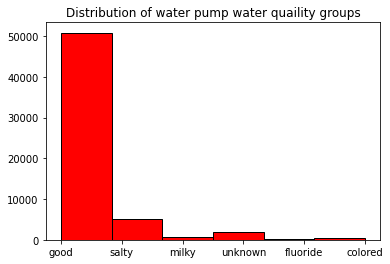

In [155]:
train_vals.quality_group.hist(grid=False, bins=6, color='red', edgecolor='black')
plt.title('Distribution of water pump water quaility groups')

In [177]:
train2 = pd.merge(train_vals, train_labs, on='id')
pd.set_option('display.max_columns', None)

train2.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  \
0  34.938093  -9.856322                  none            0   
1  34.698766  -2.147466              Zahanati            0   
2  37.460664  -3.821329           Kwa Mahundi            0   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4  31.130847  -1.825359               Shuleni            0   

                     basin  subvillage   region  region_code  district_code  \
0               Lake Nyasa    Mnyusi B   Iringa           11              5   
1            Lake Victoria     Nyamara     Mara           20              2   
2                  Pangani     Majengo  Manyara           21              4   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara           90             63   
4            Lake Victoria  Kyanyamisa   Kagera           18              1   

         lga        ward  population public_meeting              recorded_by  \
0     Ludewa    Mundindi         109           True  GeoData Consultants Ltd   
1  Serengeti       Natta         280            NaN  GeoData Consultants Ltd   
2  Simanjiro     Ngorika         250           True  GeoData Consultants Ltd   
3   Nanyumbu    Nanyumbu          58           True  GeoData Consultants Ltd   
4    Karagwe  Nyakasimbi           0           True  GeoData Consultants Ltd   

  scheme_management                  scheme_name permit  construction_year  \
0               VWC                        Roman  False               1999   
1             Other                          NaN   True               2010   
2               VWC  Nyumba ya mungu pipe scheme   True               2009   
3               VWC                          NaN   True               1986   
4               NaN                          NaN   True                  0   

  extraction_type extraction_type_group extraction_type_class management  \
0         gravity               gravity               gravity        vwc   
1         gravity               gravity               gravity        wug   
2         gravity               gravity               gravity        vwc   
3     submersible           submersible           submersible        vwc   
4         gravity               gravity               gravity      other   

  management_group         payment payment_type water_quality quality_group  \
0       user-group    pay annually     annually          soft          good   
1       user-group       never pay    never pay          soft          good   
2       user-group  pay per bucket   per bucket          soft          good   
3       user-group       never pay    never pay          soft          good   
4            other       never pay    never pay          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  \
0  groundwater           communal standpipe    communal standpipe   
1      surface           communal standpipe    communal standpipe   
2      surface  communal standpipe multiple    communal standpipe   
3  groundwater  communal standpipe multiple    communal standp

status_group   functional  functional needs repair  non functional
quality_group                                                     
colored               246                       54             190
fluoride              157                       13              47
good                28760                     3904           18154
milky                 438                       14             352
salty                2394                      297            2504
unknown               264                       35            1577


<AxesSubplot:xlabel='quality_group'>

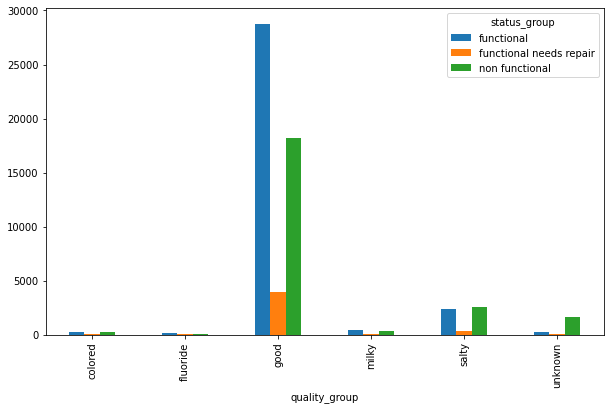

In [175]:
data_plot=pd.crosstab(index=train2['quality_group'],columns=train2['status_group'])
print(CrosstabResult)
data_plot.plot.bar(figsize=(10,6))

status_group   functional  functional needs repair  non functional
quality_group                                                     
colored               246                       54             190
fluoride              157                       13              47
good                28760                     3904           18154
milky                 438                       14             352
salty                2394                      297            2504
unknown               264                       35            1577


<AxesSubplot:xlabel='extraction_type_class'>

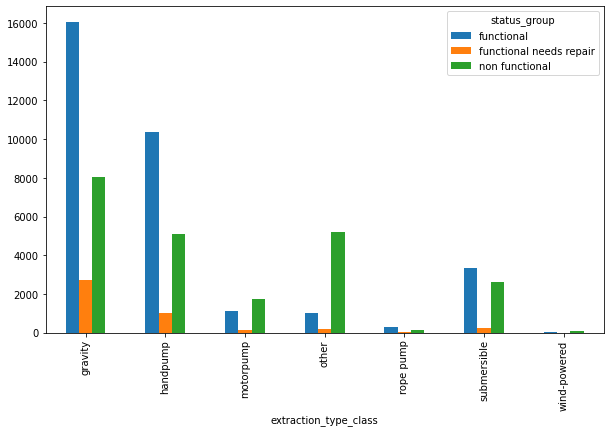

In [180]:
data_plot2=pd.crosstab(index=train2['extraction_type_class'],columns=train2['status_group'])
print(CrosstabResult)
data_plot2.plot.bar(figsize=(10,6))

status_group   functional  functional needs repair  non functional
quality_group                                                     
colored               246                       54             190
fluoride              157                       13              47
good                28760                     3904           18154
milky                 438                       14             352
salty                2394                      297            2504
unknown               264                       35            1577


<AxesSubplot:xlabel='quantity'>

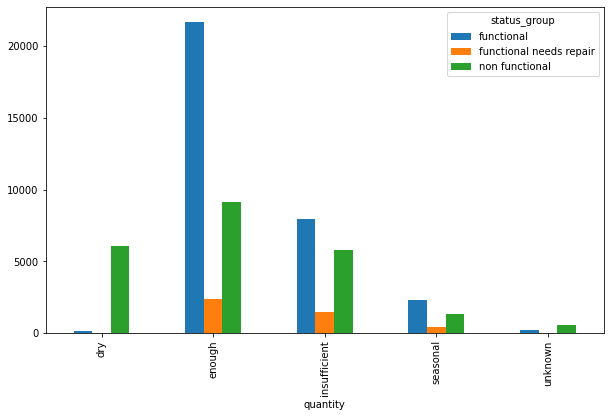

In [181]:
data_plot3=pd.crosstab(index=train2['quantity'],columns=train2['status_group'])
print(CrosstabResult)
data_plot3.plot.bar(figsize=(10,6))